In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eigh

def annihilation(d):
    return np.diag(np.sqrt(np.arange(1, d)), 1)

def creation(d):
    return annihilation(d).T

Full simulation

In [59]:
# Parameters
def state_index(index,dim):
    n,k = index
    N,K = dim
    return n*K+k
def Hamiltonian(omega3):
    d1 = d2 = 10
    omega1 = 5 * 2 * np.pi
    delta1 = -0.24 * 2 * np.pi
    delta3 = -0.14 * 2 * np.pi
    g13 = 0.1 * 2 * np.pi

    # Create operators
    a1, a3 = [annihilation(d) for d in (d1, d2)]
    a1d, a3d = [creation(d) for d in (d1, d2)]
    I1,  I3 = [np.eye(d) for d in (d1, d2)]

    # Construct Hamiltonians
    H1 = omega1 * a1d @ a1 
    H3 = omega3 * a3d @ a3 

    H1 = np.kron(I3, H1)
    H3 = np.kron(H3, I1)

    Hint13 = g13 * np.kron(a3d + a3,  a1d + a1)

    # Total Hamiltonian
    H = H1 + H3 + Hint13
    
    Hc = np.kron((a3d + a3)@(a3d+a3),  I1)
    return H, Hc



In [60]:
import qutip as qt
def find_optimal_k(A, B, D):
    # Define a large initial minimum difference
    min_diff = float('inf')
    optimal_k = None
    
    # Iterate over a range of possible k values
    # The range can be adjusted based on expected size of k or other insights you have about your problem
    for k in range(-1000, 1000):
        # Calculate the difference for this value of k
        diff = abs(A - (B + k * D))
        
        # If this is the smallest difference we've found so far, update min_diff and optimal_k
        if diff < min_diff:
            min_diff = diff
            optimal_k = k
            
    return optimal_k
# Function to calculate overlap (you might use inner product, fidelity, etc.)
def calculate_overlap(state1, state2):
    return abs((state1.dag() * state2))**2


In [61]:

def calculate_floquet_energies(A, omega,omega3):
    # Define system parameters
    dim = [5, 5]
    H0, Hc = Hamiltonian(omega3)
    index01 = state_index([0,1], dim)
    
    omega1 = np.diag(H0)[index01]

    H0 = qt.Qobj(H0)
    Hc = qt.Qobj(Hc)

    T = (2 * np.pi) / omega

    # Define the Hamiltonian
    H = [H0, [Hc, lambda t, args: A * np.cos(args['w'] * t)]]

    # Set up the Floquet solver
    floquet_basis = qt.FloquetBasis(H, T, args={'w': omega})

    # Compute Floquet modes and energies
    f_modes = floquet_basis.mode(0)
    f_energies = floquet_basis.e_quasi

    # Define basis states
    basis_states = [qt.basis(H0.dims[0][0], 0), 
                    qt.basis(H0.dims[0][0], index01)]

    # Find Floquet states with maximum overlap
    max_overlap_indices = [-1] * 2
    max_overlaps = [0] * 2
    for f_index, f_state in enumerate(f_modes):
        for b_index, b_state in enumerate(basis_states):
            overlap = calculate_overlap(f_state, b_state)
            if overlap > max_overlaps[b_index]:
                max_overlaps[b_index] = overlap
                max_overlap_indices[b_index] = f_index

    # Calculate energies
    energy00 = f_energies[max_overlap_indices[0]] / (2 * np.pi)

    energy01 = f_energies[max_overlap_indices[1]] / (2 * np.pi)
    k = find_optimal_k(omega1 / (2 * np.pi), energy01, omega / (2 * np.pi))
    energy01 = energy01 + k * omega / (2 * np.pi) - energy00

    return energy01*2*np.pi

In [62]:
3.47286432160804-5

-1.5271356783919598

In [65]:
(3.5+5)/2

4.25

In [68]:
def calculate_derivatives(A, omegad,omega3):
    energy01 = calculate_floquet_energies(A, omegad, omega3)
    epsilon = 1e-6
    energy01_ = calculate_floquet_energies(A, omegad, omega3 + epsilon)
    der1 = (energy01_ - energy01) / epsilon
    return der1, omegad/2/np.pi
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
def sweep_floquet_energies_derivatives(A, omega3, omega_range):
    der_values = Parallel(n_jobs=-1)(delayed(calculate_derivatives)(A, omegad, omega3) for omegad in omega_range)
    der_values, omega_vals = zip(*der_values)
    return omega_vals, der_values
def sweep_energy(A, omega3_range, omegad):
    energy_values = Parallel(n_jobs=-1)(delayed(calculate_floquet_energies)(A, omegad, omega3) for omega3 in omega3_range)
    return omega3_range, energy_values

omega3 = 3.47286432160804*2*np.pi
A = 0.03*2*np.pi
# omegad = np.linspace(3.3846*2*np.pi,3.3848*2*np.pi,50)
omega_range = np.linspace(4*2*np.pi,4.4*2*np.pi,100)
omega_vals, der1_values, = sweep_floquet_energies_derivatives(A, omega3, omega_range)
# omega_vals, energy_values = sweep_energy(A, omega3, omega_range)

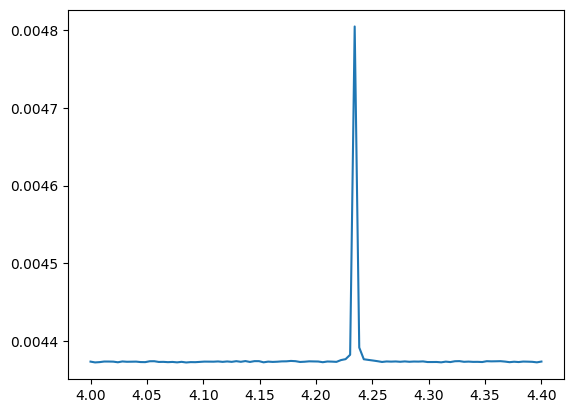

In [70]:
plt.plot(omega_vals, der1_values)
# plt.yscale('log')

check with rwa

In [13]:
def sort_eigenpairs(eigenvalues, eigenvectors):
    n = eigenvectors.shape[0]
    sorted_indices = []

    for i in range(n):
        max_abs_vals = np.abs(eigenvectors[i, :])
        max_index = np.argmax(max_abs_vals)
        while max_index in sorted_indices:
            max_abs_vals[max_index] = -np.inf
            max_index = np.argmax(max_abs_vals)
        sorted_indices.append(max_index)

    sorted_eigenvalues = eigenvalues[sorted_indices]
    sorted_eigenvectors = eigenvectors[:, sorted_indices]

    return sorted_eigenvalues, sorted_eigenvectors

def floquetapp(A,omegad,omega3):
    d1 = d2 = 5
    omega1 = 5 * 2 * np.pi
    delta1 = -0.24 * 2 * np.pi
    delta3 = -0.14 * 2 * np.pi
    g13 = 0.11 * 2 * np.pi

    # Create operators
    a1, a3 = [annihilation(d) for d in (d1, d2)]
    a1d, a3d = [creation(d) for d in (d1, d2)]
    I1,  I3 = [np.eye(d) for d in (d1, d2)]

    # Construct Hamiltonians
    H1 = omega1 * a1d @ a1 + delta1/2 * a1d @ a1d @ a1 @ a1
    H3 = omega3 * a3d @ a3 + delta3/2 * a3d @ a3d @ a3 @ a3

    H1 = np.kron(I3, H1)
    H3 = np.kron(H3, I1)

    Hint13 = g13 * np.kron(a3d + a3,  a1d + a1)

    # Total Hamiltonian
    H = H1 + H3 + Hint13
    
    Hc = np.kron(a3d + a3,  I1)

    # Diagonalize
    eigenvalues, _ = eigh(H)
    eigenvalues -= eigenvalues[0]
    eigenvalues,_ = sort_eigenpairs(eigenvalues,_) 
    dim = [5,5]
    index01 = state_index([0,1],dim)
    index10 = state_index([1,0],dim)
    index11 = state_index([1,1],dim)


    
    chi12 = eigenvalues[index11]-eigenvalues[index10]-eigenvalues[index01]
    omega1 = eigenvalues[index01]
    omega3 = eigenvalues[index10]
    
    H1 = omega1 * a1d @ a1 + delta1/2 * a1d @ a1d @ a1 @ a1
    delta = omega3 - omegad
    H3 = delta * a3d @ a3 + delta3/2 * a3d @ a3d @ a3 @ a3
    
    H1 = np.kron(I3, H1)
    H3 = np.kron(H3, I1)
    
    Hint12 = chi12 * np.kron(a3d @ a3, a1d @ a1)
    H = H1 + H3 + Hint12 + A/2*Hc
    eigenvalues, _ = eigh(H)
    eigenvalues,U = sort_eigenpairs(eigenvalues,_) 
    Ud = U.conj().T
    a10 = ((Ud@np.kron(a3,I1)@U)[5,0])**2
    ada10 = ((Ud@np.kron(a3d@a3,I1)@U)[5,0])**2
    eigenvalues -= eigenvalues[0]
    
    E1 = eigenvalues[index01]
    chi = eigenvalues[index11]-eigenvalues[index10]-eigenvalues[index01]
    delta = eigenvalues[index10]
    return E1,chi,delta, a10,ada10

In [14]:
def calculate_derivatives(A, omegad, omega3):
    energy01,chi,delta, a10, ada10= floquetapp(A, omegad, omega3)
    epsilon = 1e-6
    energy01_,chi_, delta_, a10_, ada10_ = floquetapp(A, omegad, omega3 + epsilon)
    der1 = (energy01_ - energy01) / epsilon
    return der1, omegad/2/np.pi, chi,delta,  a10, ada10

import matplotlib.pyplot as plt
from joblib import Parallel, delayed

def sweep_floquet_energies_derivatives(A, omega3, omega_range):
    der_values = Parallel(n_jobs=-1)(delayed(calculate_derivatives)(A, omegad, omega3) for omegad in omega_range)
    der_values, omega_vals, chis, deltas, a10s, ada10s = zip(*der_values)
    return omega_vals, der_values, chis, deltas, a10s, ada10s

In [15]:

omega3 = 3.47286432160804*2*np.pi
A = 0.003*2*np.pi
# omegad = np.linspace(3.3846*2*np.pi,3.3848*2*np.pi,50)
omega_range = np.linspace(3.385*2*np.pi,3.52*2*np.pi,1000)
# omega_range = np.linspace(3.45*2*np.pi,3.5*2*np.pi,1000)
omega_vals, der1_values1, chis, deltas, a10s, ada10s = sweep_floquet_energies_derivatives(A, omega3, omega_range)

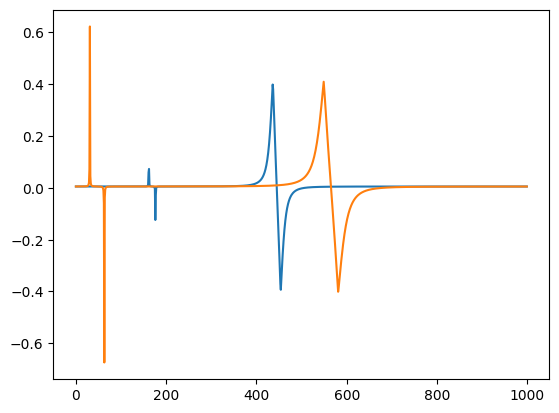

In [16]:
plt.plot(der1_values)
plt.plot(der1_values1)

In [35]:
def f1_rate(der):
    A = 0.9*2*np.pi*1e6
    factor = np.sqrt(np.abs(np.log(2*np.pi*1e-5)*2))
    return der * A * factor/2/np.pi
def SBw(freq):
    A = 5*1e-6*2.24*2*(np.pi)**2*1e9
    return A**2/np.abs(freq)
def shot_noise(me, freq,chi):
    gamma = 2e5*2*np.pi
    n_bar = 2*me*SBw(freq)/gamma
    ratio = chi*1e9 / gamma
    factor = np.real(np.sqrt(((1 + 1j*ratio)**2 + 4*1j*ratio*n_bar)) - 1) / 2
    return (gamma * factor)

In [38]:
def f1_rate(der):
    A = 0.9*2*np.pi*1e6
    factor = np.sqrt(np.abs(np.log(2*np.pi*1e-5)*2))
    return der * A * factor/2/np.pi
def SBw(freq):
    A = 5*1e-6*2.24*2*(np.pi)**2*1e9
    return A**2/np.abs(freq)
def shot_noise(me, freq,chi):
    gamma = 2e5*2*np.pi
    n_bar = 2*me*SBw(freq)/gamma
    print(2*me*SBw(freq))
    ratio = chi*1e9 / gamma
    factor = np.real(np.sqrt(((1 + 1j*ratio)**2 + 4*1j*ratio*n_bar)) - 1) / 2
    return (gamma * factor)

In [48]:
2*me*SBw(freq)

24.892335019370517

In [46]:
drive = 0.01*2*np.pi*1e9/2
detu = (6.184 - 6.159) *2*np.pi*1e9
me = drive / detu
me = me**2
freq = detu
chi = -0.0059*2*np.pi
shot_noise(me, freq,chi)

24.892335019370517


24.86376249679785

In [47]:
detu/1e9/2/np.pi

0.025000000000000352

In [44]:
SBw(detu)

311.15418774214027

In [37]:
me

0.03999999999999887

In [34]:
5*1e-6*2.24*2*(np.pi)**2*1e9/1e6


0.2210791385844016

In [16]:
me

0.03999999999999887

In [21]:
np.sqrt(np.abs(np.log(2*np.pi*1e-5)*2))

4.398874492085648

In [22]:
4.4*4

17.6

In [23]:
1/f1_rate(1)*1e6

0.2525898643187471

In [24]:
a10_shot = []
ada10_shot = []
n_bar = []
for i in range(len(der1_values1)):
    # a10_shot.append(shot_noise(a10s[i],deltas[i]*1e9,chis[i]))
    ada10_shot.append(shot_noise(ada10s[i],deltas[i]*1e9,chis[i]))
    n_bar.append(ada10s[i]*SBw(deltas[i]*1e9)/(1e5*2*np.pi))

In [25]:
a10_shot = np.array(a10_shot)
ada10_shot = np.array(ada10_shot)

In [27]:
20/1.5

13.333333333333334

In [26]:
import plotly.express as px
import numpy as np

# ...existing code...
# omega_vals, der1_values1 already defined

fig = px.line(
    x=omega_vals,
    y=[f1_rate(np.abs(der1_values1))/1e3, ada10_shot/1e3],
    labels={'x': 'omega', 'y': 'value'},
    log_y=True
)
fig.show()


In [15]:
1.34*1e-4

4.398874492085648

In [592]:
fig = px.line(
    x=omega_vals,
    y=a10s,
    labels={'x': 'omega', 'y': '|der1_values1|'},
    log_y=True
)
fig.show()

optimize to get sweet spot frequency for a given drive amplitude

In [573]:
(1/f1_rate(1))

1.1368210220849668e-06

In [514]:
# from qutip import Qobj, qsave,qload
# # Save the Qobj
# ada_expr = qload('./symbolic/ada')
# a_expr = qload('./symbolic/a')
# from sympy.physics.quantum import TensorProduct
# from sympy import symbols, sqrt
# anh_sym  = symbols('K_a', real=True)
# delta_sym = symbols('delta',real = True)
# A_sym = symbols('A', real=True)
# delta = omega3 - min_omega*2*np.pi
# A_value = A
# print(ada_expr.subs(A_sym,A).subs(anh_sym, delta3).subs(delta_sym, delta))
# print(a_expr.subs(A_sym,A).subs(anh_sym, delta3).subs(delta_sym, delta))